In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from mie2c.e2c import E2C, compute_loss
from mie2c.ball_model import get_ball_encoder, get_ball_decoder, get_ball_transition

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [216]:
n = 4 
dh = 0.025

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
NUM_DATA = 1000
# NUM_DATA = 2

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 500

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

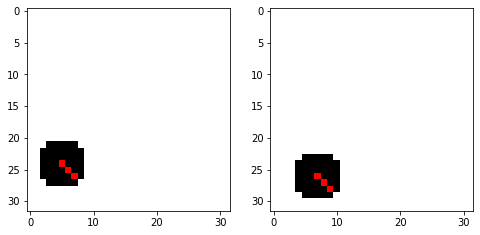

In [217]:
idx = 0
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [218]:
dim_in = X[0].shape
dim_z = 6
dim_u = 1

encoder = get_ball_encoder(dim_in, dim_z) 
transition = get_ball_transition(dim_z, dim_u)
decoder = get_ball_decoder(dim_z, dim_in) 

model = E2C(encoder, transition, decoder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


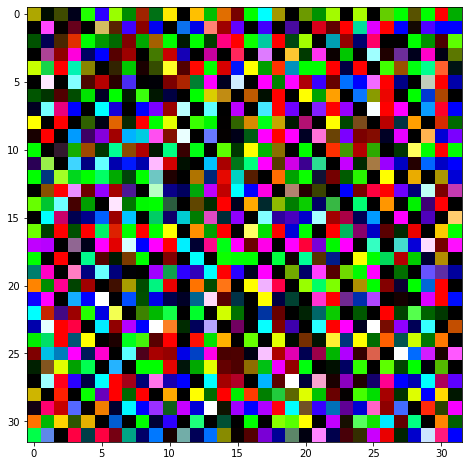

In [219]:
inp = torch.from_numpy(X[:2]).float()
mean, logvar = model.encode(inp)
x_dec = model.decode(mean)[0]

fig = plt.figure(figsize=(8,8))

# fig.add_subplot(1,1,1)
plt.imshow(x_dec.detach().numpy().transpose(1,2,0))

## Training loop

In [221]:
BATCH_SIZE = 200
dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(),torch.tensor(X_next).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.Adam(model.parameters())

In [308]:
# training parameters
NUM_EPOCH = 100

# KL_LAMBDA = 1.

for epoch in range(NUM_EPOCH):
    ii = 0
    for x, x_next in dataloader:
        optimizer.zero_grad()
        action = torch.zeros((x.shape[0], 1)).float()
        
#         next_pre_rec = model(x, action, x_next)
#         x_dec = model(x, action, x_next)
    
#         loss_rec, loss_trans = compute_loss(\
#             model.x_dec, model.x_next_pred_dec, \
#             x, x_next, \
#             model.Qz, model.Qz_next_pred, model.Qz_next, mse=True)
      
#         loss = loss_rec + KL_LAMBDA * loss_trans

#         loss_rec, loss_trans = compute_loss(\
#             model.x_dec, model.x_next_pred_dec, \
#             x, x_next, \
#             model.Qz, model.Qz_next_pred, model.Qz_next, mse=True)

        model(x, action, x_next)
        loss = compute_loss(model.x_dec, model.x_next_dec, x, x_next, model.Qz, model.Qz_next, mse=True)

#         print("rec: " + str(loss_rec.item()))
#         print("trans: " + str(loss_trans.item()))
        if ii % 10 == 0:
            print(loss.item())
        
        loss.backward()
        optimizer.step()
        ii += 1

36.160804748535156
34.968807220458984
34.69626235961914
34.927364349365234
34.39984893798828
34.42072677612305
34.10264587402344
34.989898681640625
35.93961715698242
33.78919219970703
35.43504333496094
35.22930908203125
34.27687072753906
33.866756439208984
34.94696807861328
34.483314514160156
34.626182556152344
34.720916748046875
34.30366516113281
33.873382568359375
33.778682708740234
33.90135955810547
34.09946060180664
35.16689682006836
44.44017028808594
40.83412551879883
36.484859466552734
36.609188079833984
36.4235725402832
35.834415435791016
34.891902923583984
33.736289978027344
33.857269287109375
34.64679718017578
32.49872589111328
34.1820182800293
34.6478157043457
33.64399719238281
34.65459060668945
33.95561218261719
35.10650634765625
34.9466667175293
34.625831604003906
34.36756896972656
34.399635314941406
34.16144561767578
34.470130920410156
32.85871505737305
34.02386474609375
33.51743698120117
32.889076232910156
32.895999908447266
32.796653747558594
33.06748580932617
33.4324188

In [309]:
x_pred = model.predict(torch.tensor(X).float(), torch.zeros(NUM_DATA,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


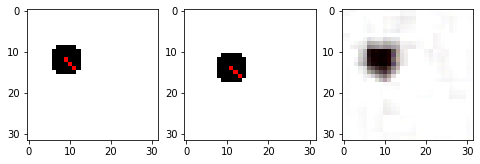

In [310]:
idx = np.random.choice(NUM_DATA)
img, img_next, img_next_pred = X[idx], X_next[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))

In [311]:
x_pred = model.predict(torch.tensor(X_test).float(), torch.zeros(NUM_TEST,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


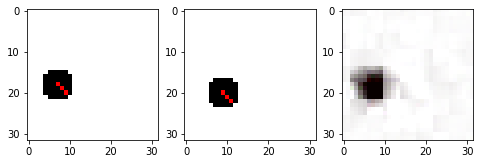

In [323]:
idx = np.random.choice(NUM_TEST)
img, img_next, img_next_pred = X_test[idx], X_next_test[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))